In [21]:
import numpy as np
import sympy as sp

%matplotlib nbagg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pyJHTDB
from pyJHTDB import libJHTDB
from pyJHTDB.dbinfo import interpolation_code
from pyJHTDB.dbinfo import channel as info

import pickle
import time

In [22]:
nu = 5e-5
T  = 25.9935

Lx = info['lx']
Ly = info['ly']
Lz = info['lz']

Top = Ly/2
Bottom = -Ly/2
eps = Ly/100


npoints = 2
nparticles = 10
database_dt = 0.0065
nsteps = int(T/database_dt) #info['time'].shape[0]
subdivisions = 2

x0         = np.zeros(shape = (npoints, nparticles, 3), dtype = np.float32)
x0[..., 0] = Lx*np.random.random(size = (npoints,))[:, None]
x0[..., 1] = 0*info['ynodes'][info['ynodes'].shape[0]//10]
x0[..., 2] = Lz*np.random.random(size = (npoints,))[:, None]


subdivisions = 2
t = np.linspace(T, info['time'][0], num = subdivisions*nsteps+1)
tau = t[0] - t
dt              = t[0] - t[1]
sqrtdt          = abs(dt)**.5

numcombs   = np.float(nparticles*(nparticles-1)/2)
trytimes = [1,3,10,30,100,300,1000] #waiting times in case database fails 

In [23]:
#pickle.dump(x0, open( "data_channel/x0.p", "wb" ) )
x0 = pickle.load( open( "data_channel/x0.p", "rb" ) )

PrandtlNumbers = np.array([1e1, 1e0, 1e-1])
for m in range(PrandtlNumbers.shape[0]):
    xfull  = np.zeros(shape = (subdivisions*nsteps+1, npoints, nparticles, 3), dtype = np.float32)
    LBfull = np.zeros(shape = (subdivisions*nsteps+1, npoints, nparticles, 3), dtype = np.float32)
    LTfull = np.zeros(shape = (subdivisions*nsteps+1, npoints, nparticles, 3), dtype = np.float32)
    
    Prandtl = np.float(PrandtlNumbers[m])
    kappa = nu/Prandtl
    noiseamplitude  = (2*kappa)**.5
    
    xfull[0] = x0.copy() 
    lJHTDB = libJHTDB()
    lJHTDB.initialize()
    for tindex in range(subdivisions*nsteps):
        print('step {0} of {1} for Pr = {2}'.format(tindex,subdivisions*nsteps, Prandtl))
        
        for tryT in trytimes:  
            try:
                u = lJHTDB.getData(
                            t[tindex],
                            xfull[tindex],
                            sinterp = interpolation_code['M2Q8'],
                            tinterp = interpolation_code['NoTInt'],
                            data_set = info['name'],
                            getFunction = 'getVelocity')
                break
            except Exception as e:
                print e
                time.sleep(tryT)
                
        dW = np.random.randn(*xfull.shape[1:])*sqrtdt
        dX = -u*dt + noiseamplitude*dW
        xfull[tindex + 1] = xfull[tindex] + dX
        cond1 = xfull[tindex][..., 1] < Bottom + eps
        cond2 = xfull[tindex][..., 1] > Top    - eps
        c1indices = np.where(cond1)   
        if c1indices[0].size > 0:
            V  =  -2*dt*np.log(np.random.random(xfull.shape[1:]))[c1indices]
            Y  = (-dX[c1indices] + np.sqrt(2*kappa*V + dX[c1indices]**2))/2.0
            dL =  Y - xfull[tindex][c1indices] + Bottom
            dL[np.where(dL < 0)] = 0
            xfull[tindex + 1][c1indices]  += dL
            LBfull[tindex + 1][c1indices] += dL/kappa
        c2indices = np.where(cond2) 
        if c2indices[0].size > 0:
            V  =  -2*dt*np.log(np.random.random(xfull.shape[1:]))[c2indices]
            Y  = (-dX[c2indices] + np.sqrt(2*kappa*V + dX[c2indices]**2))/2.0
            dL =  Y + xfull[tindex][c2indices] - Top
            dL[np.where(dL < 0)] = 0
            xfull[tindex + 1][c2indices]  -= dL
            LTfull[tindex + 1][c2indices] += dL/kappa
        xfull[tindex+1][..., 1] = np.clip(xfull[tindex+1][..., 1], Bottom, Top)
    lJHTDB.finalize() 
    
    ####### Dump Data #######
    suffix = 'middle_Traj_{0}_Pr_{1}.p'.format(nparticles, Prandtl)
    pickle.dump(xfull,  open( "data_channel/xfull"          + suffix, "wb" ) )
    pickle.dump(t,      open( "data_channel/t"                  + suffix, "wb" ) )
    pickle.dump(LTfull, open( "data_channel/LTfull"        + suffix, "wb" ) )
    pickle.dump(LBfull, open( "data_channel/LBfull"        + suffix, "wb" ) )

step 0 of 7998 for Pr = 10.0
step 1 of 7998 for Pr = 10.0
step 2 of 7998 for Pr = 10.0
step 3 of 7998 for Pr = 10.0
step 4 of 7998 for Pr = 10.0
step 5 of 7998 for Pr = 10.0
step 6 of 7998 for Pr = 10.0
step 7 of 7998 for Pr = 10.0
step 8 of 7998 for Pr = 10.0
step 9 of 7998 for Pr = 10.0
step 10 of 7998 for Pr = 10.0
step 11 of 7998 for Pr = 10.0
step 12 of 7998 for Pr = 10.0
step 13 of 7998 for Pr = 10.0
step 14 of 7998 for Pr = 10.0
step 15 of 7998 for Pr = 10.0
step 16 of 7998 for Pr = 10.0
step 17 of 7998 for Pr = 10.0
step 18 of 7998 for Pr = 10.0
step 19 of 7998 for Pr = 10.0
step 20 of 7998 for Pr = 10.0
step 21 of 7998 for Pr = 10.0


KeyboardInterrupt: 

In [8]:
PrandtlNumbers = np.array([1e1, 1e0, 1e-1])
####### Load Data #######
nparticles = 10
Prandtl1 = PrandtlNumbers[0]
Prandtl2 = PrandtlNumbers[1]
Prandtl3 = PrandtlNumbers[2]
suffix1  = 'middle_Traj_{0}_Pr_{1}.p'.format(nparticles, Prandtl1)
suffix2  = 'middle_Traj_{0}_Pr_{1}.p'.format(nparticles, Prandtl2)
suffix3  = 'middle_Traj_{0}_Pr_{1}.p'.format(nparticles, Prandtl3)
t        = pickle.load( open( "data_channel/t"         + suffix1, "rb" ) )
xfull1   = pickle.load( open( "data_channel/xfull"     + suffix1, "rb" ) )
LTfull1  = pickle.load( open( "data_channel/LTfull"    + suffix1, "rb" ) )
LBfull1  = pickle.load( open( "data_channel/LBfull"    + suffix1, "rb" ) )
xfull2   = pickle.load( open( "data_channel/xfull"     + suffix2, "rb" ) )
LTfull2  = pickle.load( open( "data_channel/LTfull"    + suffix2, "rb" ) )
LBfull2  = pickle.load( open( "data_channel/LBfull"    + suffix2, "rb" ) )
xfull3   = pickle.load( open( "data_channel/xfull"     + suffix3, "rb" ) )
LTfull3  = pickle.load( open( "data_channel/LTfull"    + suffix3, "rb" ) )
LBfull3  = pickle.load( open( "data_channel/LBfull"    + suffix3, "rb" ) )

In [9]:
print np.max(LBfull1)
print np.max(LBfull2)
print np.max(LBfull3)

0.0
0.0
0.0


<IPython.core.display.Javascript object>


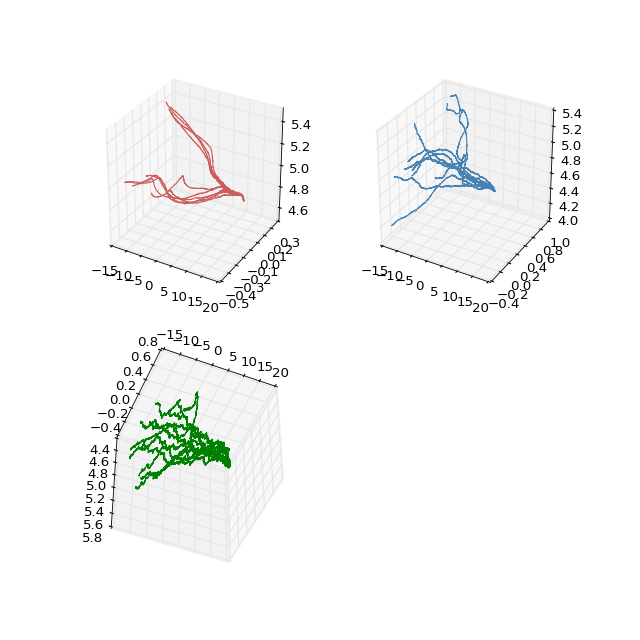

In [10]:
space_indx = 1

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(221, projection = '3d')
ax2 = fig.add_subplot(222, projection = '3d')
ax3 = fig.add_subplot(223, projection = '3d')
for traj in range(xfull1.shape[2]):
    ax1.plot(xfull1[:, space_indx, traj, 0],
             xfull1[:, space_indx, traj, 1],
             xfull1[:, space_indx, traj, 2],
             color = 'Indianred')
for traj in range(xfull2.shape[2]):
    ax2.plot(xfull2[:, space_indx, traj, 0],
             xfull2[:, space_indx, traj, 1],
             xfull2[:, space_indx, traj, 2],
             color = 'Steelblue')
for traj in range(xfull3.shape[2]):
    ax3.plot(xfull3[:, space_indx, traj, 0],
             xfull3[:, space_indx, traj, 1],
             xfull3[:, space_indx, traj, 2],
             color = 'green')

<IPython.core.display.Javascript object>


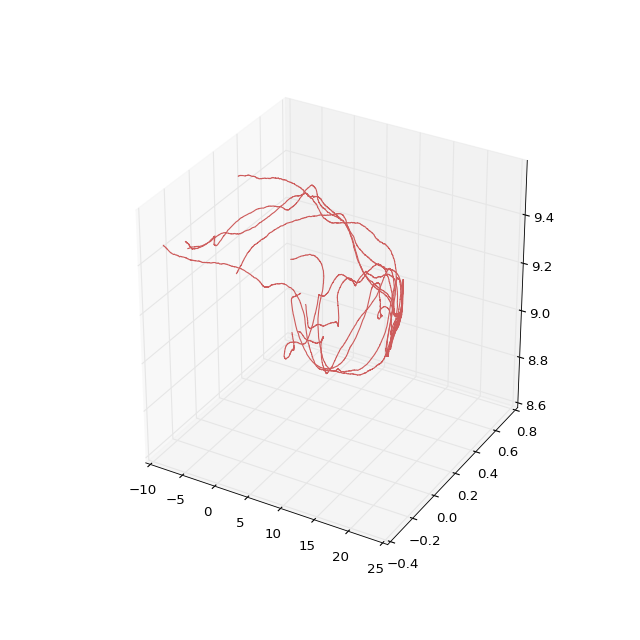

In [11]:
space_indx = 0
xx = xfull1
fig = plt.figure(figsize=(8,8))
ax3 = fig.add_subplot(111, projection = '3d')
for traj in range(xfull3.shape[2]):
    ax3.plot(xx[:, space_indx, traj, 0],
             xx[:, space_indx, traj, 1],
             xx[:, space_indx, traj, 2],
             color = 'Indianred')

<IPython.core.display.Javascript object>


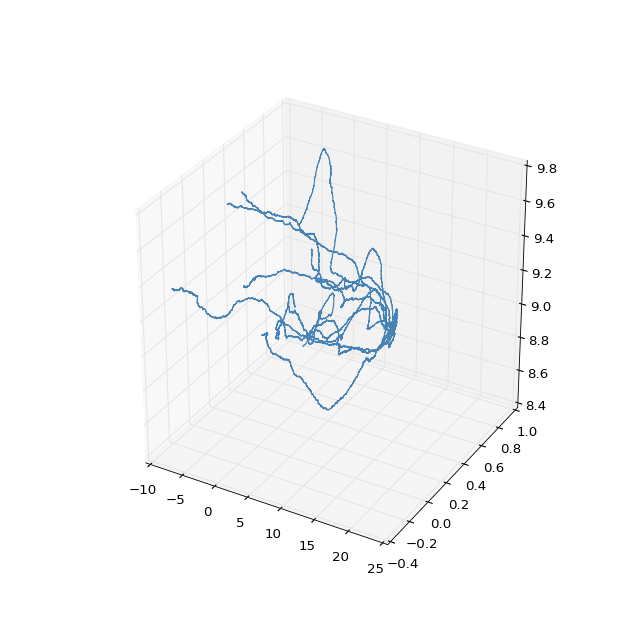

In [12]:
space_indx = 0
xx = xfull2
fig = plt.figure(figsize=(8,8))
ax3 = fig.add_subplot(111, projection = '3d')
for traj in range(xfull3.shape[2]):
    ax3.plot(xx[:, space_indx, traj, 0],
             xx[:, space_indx, traj, 1],
             xx[:, space_indx, traj, 2],
             color = 'Steelblue')

<IPython.core.display.Javascript object>


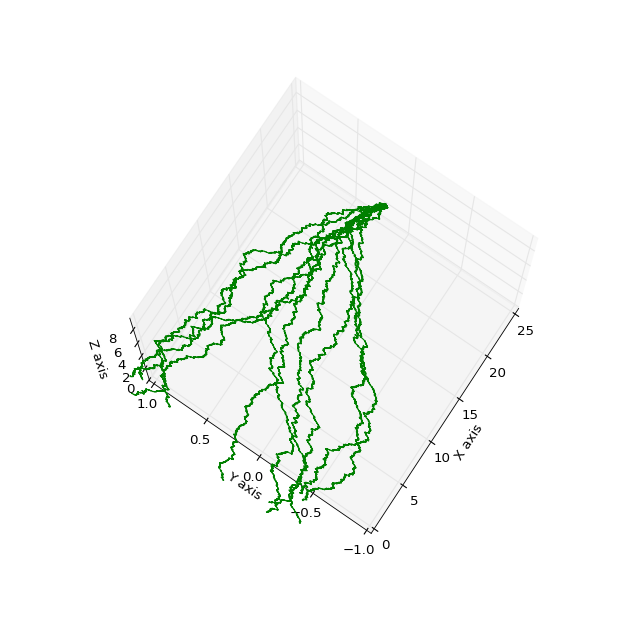

In [14]:
space_indx = 0
xx = xfull3
fig = plt.figure(figsize=(8,8))
ax3 = fig.add_subplot(111, projection = '3d')
for traj in range(xfull3.shape[2]):
    ax3.plot(xx[:, space_indx, traj, 0],
             xx[:, space_indx, traj, 1],
             xx[:, space_indx, traj, 2],
             color = 'green')

ax3.set_xlim3d(0 , 8*np.pi)
ax3.set_ylim3d(-Ly/2, Ly/2)
ax3.set_zlim3d(0, 3*np.pi)

ax3.set_xlabel('X axis')
ax3.set_ylabel('Y axis')
ax3.set_zlabel('Z axis')

<IPython.core.display.Javascript object>


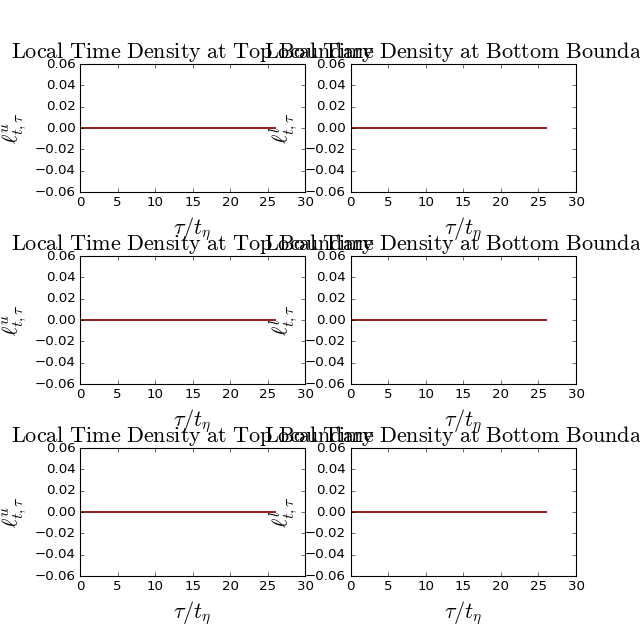

In [16]:
space_indx    = 1
fig  = plt.figure(figsize=(8,8))
ax11 = fig.add_subplot(3,2,1)
ax12 = fig.add_subplot(3,2,2)
ax21 = fig.add_subplot(3,2,3)
ax22 = fig.add_subplot(3,2,4)
ax31 = fig.add_subplot(3,2,5)
ax32 = fig.add_subplot(3,2,6)
fig.subplots_adjust(hspace=.5)

for traj in range(LTfull1.shape[2]):
    ax11.plot(tau, LTfull1[:, space_indx, traj, 1])
ax11.set_title('$\\rm Local\ Time\ Density\ at\ Top\ Boundary$', fontsize=20)
ax11.set_xlabel('$\\tau / t_\\eta$', fontsize=20)
ax11.set_ylabel('$\\ell^u_{t,\\tau}$', fontsize=20)

for traj in range(LBfull1.shape[2]):
    ax12.plot(tau, LBfull1[:, space_indx, traj, 1])
ax12.set_title('$\\rm Local\ Time\ Density\ at\ Bottom\ Boundary$', fontsize=20)
ax12.set_xlabel('$\\tau / t_\\eta$', fontsize=20)
ax12.set_ylabel('$\\ell^l_{t,\\tau}$', fontsize=20)

for traj in range(LTfull2.shape[2]):
    ax21.plot(tau, LTfull2[:, space_indx, traj, 1])
ax21.set_title('$\\rm Local\ Time\ Density\ at\ Top\ Boundary$', fontsize=20)
ax21.set_xlabel('$\\tau / t_\\eta$', fontsize=20)
ax21.set_ylabel('$\\ell^u_{t,\\tau}$', fontsize=20)

for traj in range(LBfull2.shape[2]):
    ax22.plot(tau, LBfull2[:, space_indx, traj, 1])
ax22.set_title('$\\rm Local\ Time\ Density\ at\ Bottom\ Boundary$', fontsize=20)
ax22.set_xlabel('$\\tau / t_\\eta$', fontsize=20)
ax22.set_ylabel('$\\ell^l_{t,\\tau}$', fontsize=20)

for traj in range(LTfull3.shape[2]):
    ax31.plot(tau, LTfull3[:, space_indx, traj, 1])
ax31.set_title('$\\rm Local\ Time\ Density\ at\ Top\ Boundary$', fontsize=20)
ax31.set_xlabel('$\\tau / t_\\eta$', fontsize=20)
ax31.set_ylabel('$\\ell^u_{t,\\tau}$', fontsize=20)

for traj in range(LBfull3.shape[2]):
    ax32.plot(tau, LBfull3[:, space_indx, traj, 1])
ax32.set_title('$\\rm Local\ Time\ Density\ at\ Bottom\ Boundary$', fontsize=20)
ax32.set_xlabel('$\\tau / t_\\eta$', fontsize=20)
ax32.set_ylabel('$\\ell^l_{t,\\tau}$', fontsize=20)